In [38]:
import numpy as np
import torch as torch
import torch.nn as nn
import torch.nn.functional as F

In [39]:
class layer(nn.Module):
  def __init__(self,input,output):
    super().__init__()
    self.layer=nn.Linear(input,output)
  def forward(self,x,activation=True):
    if(activation):
      return F.leaky_relu(self.layer(x))
    else:
      return self.layer(x)

In [40]:
class Convolution(nn.Module):
  def __init__(self,input_channels,output_channels,kernel_y,kernel_x,stride_y,stride_x,padding_y,padding_x):
    super().__init__()
    self.convolve=nn.Conv2d(input_channels,output_channels,kernel_size=(kernel_y,kernel_x),stride=(stride_y,stride_x),padding=(padding_y,padding_x))

  def forward(self,x):
    return self.convolve(x)

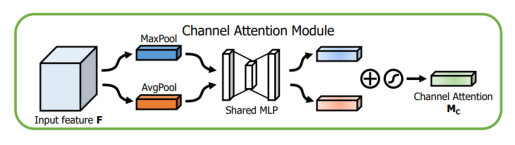

In [41]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('channel_image.png')
plt.axis('off')
plt.imshow(img)
plt.show()

In [42]:
class channel_block(nn.Module):
  def __init__(self,batch_size,no_channels,kernel_y,kernel_x,r):
    super().__init__()
    self.batch_size=batch_size
    self.no_channels=no_channels
    self.maxpool=nn.MaxPool2d(kernel_size=(kernel_y,kernel_x),stride=(kernel_y,kernel_x))
    self.avgpool=nn.AvgPool2d(kernel_size=(kernel_y,kernel_x),stride=(kernel_y,kernel_x))
    self.input=layer(no_channels,no_channels//r)
    self.output=layer(no_channels//r,no_channels)
  def forward(self,x):
    pool1=self.maxpool(x)
    pool2=self.avgpool(x)
    pool1=pool1.reshape(self.batch_size,self.no_channels)
    pool2=pool2.reshape(self.batch_size,self.no_channels)
    hidden1=self.input.forward(pool1)
    output1=self.output.forward(hidden1,False)
    hidden2=self.input.forward(pool2)
    output2=self.output.forward(hidden2,False)
    output=F.sigmoid(torch.add(output1,output2))
    z=torch.zeros(x.shape)
    for i,j in enumerate(x):
      for k,l in enumerate(j):
        z[i][k]=torch.mul(l,z[i][k])
    return z

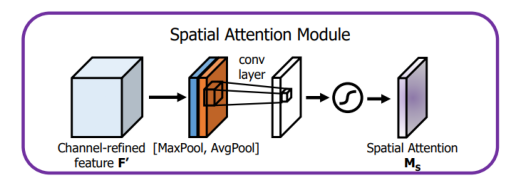

In [43]:
img = mpimg.imread('spatial_image.png')
plt.axis('off')
plt.imshow(img)
plt.show()

In [44]:
class spatial_block(nn.Module):
  def __init__(self,no_channels):
    super().__init__()
    self.maxpool=nn.MaxPool3d(kernel_size=(no_channels,1,1),stride=(no_channels,1,1))
    self.avgpool=nn.AvgPool3d(kernel_size=(no_channels,1,1),stride=(no_channels,1,1))
    self.convolution=Convolution(2,1,7,7,1,1,3,3)
  def forward(self,x):
    pool1=self.maxpool(x)
    pool2=self.avgpool(x)
    pool_net=torch.cat([pool1,pool2],dim=1)
    return self.convolution(pool_net)